# Imports

In [50]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPooling2D, GlobalAvgPool2D

import numpy as np

import matplotlib.pyplot as plt

# Load Data

In [3]:
(train_ds, test_ds), ds_info = tfds.load("cifar10", split =["train", "test"], as_supervised = True, with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Test\tensorflow_datasets\cifar10\3.0.2.incomplete5CJ1RA\cifar10-train.tfrecord*...:   0%|  …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Test\tensorflow_datasets\cifar10\3.0.2.incomplete5CJ1RA\cifar10-test.tfrecord*...:   0%|   …

Dataset cifar10 downloaded and prepared to C:\Users\Test\tensorflow_datasets\cifar10\3.0.2. Subsequent calls will reuse this data.


# Analyze Data

In [4]:
print(ds_info)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='C:\\Users\\Test\\tensorflow_datasets\\cifar10\\3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        t

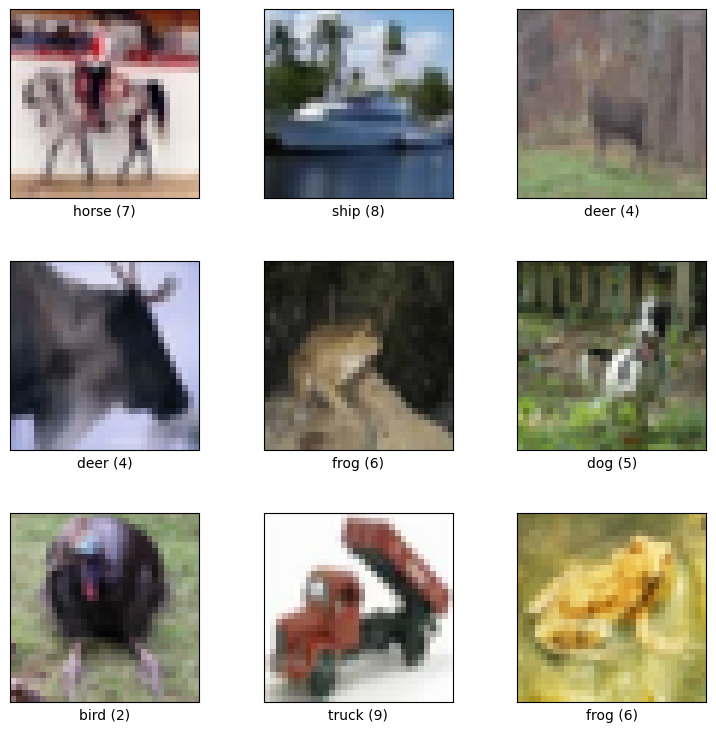

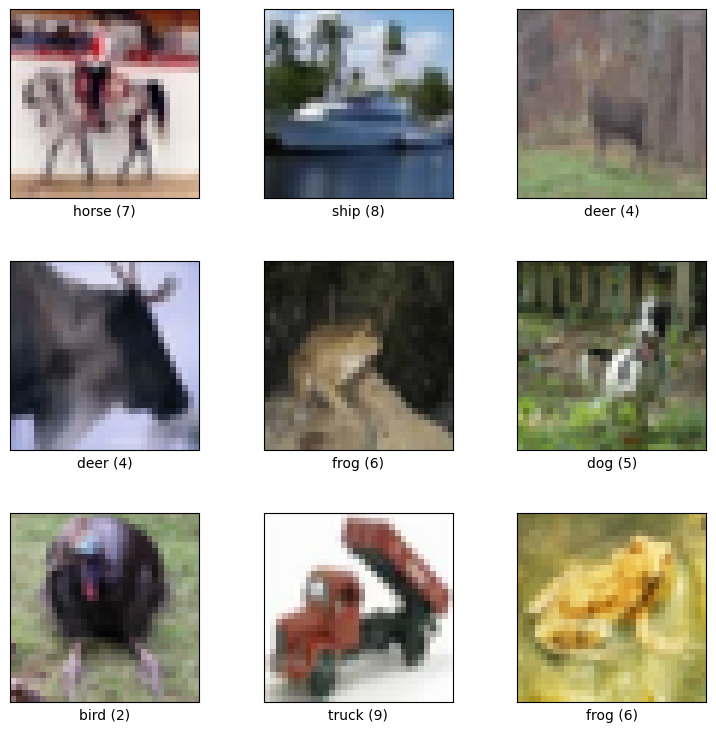

In [5]:
tfds.show_examples(train_ds, ds_info)

In [6]:
ds_info.features["image"].shape

(32, 32, 3)

In [7]:
ds_info.features["image"].tf_dtype

tf.uint8

# Preprocess Data

In [8]:
def preprocess_cifar10(cifar10_data):

    #convert data from uint8 to float32
    cifar10_data = cifar10_data.map(lambda img, target: (tf.cast(img, tf.float32), target))

    # normalize the rgb values to values from -1 and 1
    cifar10_data = cifar10_data.map(lambda img, target: ((img/128.)-1., target))
    
    # one-hot encode the target
    cifar10_data = cifar10_data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    #shuffle, batch, prefetch
    cifar10_data = cifar10_data.shuffle(1000)
    cifar10_data = cifar10_data.batch(32)
    cifar10_data = cifar10_data.prefetch(20)

    return cifar10_data

In [9]:
train_dataset   = train_ds.apply(preprocess_cifar10)
test_dataset    = test_ds.apply(preprocess_cifar10)

# Create Model

In [12]:
class Cifar10Model(tf.keras.Model):
    
    def __init__(self):
        super(Cifar10Model, self).__init__()
        self.conv_1 = Conv2D(32, (3, 3), activation = tf.nn.relu, input_shape=(32, 32, 3))
        self.pool_1 = MaxPooling2D((2,2))
        self.conv_2 = Conv2D(64, (3, 3), activation = tf.nn.relu)
        self.pool_2 = MaxPooling2D((2,2))
        self.conv_3 = Conv2D(64, (3, 3), activation = tf.nn.relu)

        self.flat_1 = Flatten()
        self.dens_1 = Dense(64, activation = tf.nn.relu)
        self.out    = Dense(10, activation = tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.pool_2(x)
        x = self.conv_3(x)
        
        x = self.flat_1(x)
        x = self.dens_1(x)
        x = self.out(x)
        return x

In [14]:
model =  Cifar10Model()

# Train

In [22]:
def train_model(epochs, model, train_ds, test_ds, loss_function, optimizer,\
                 train_losses, train_accuracies, test_losses, test_accuracies):
    
    for epoch in range(epochs):
        ### train model
        train_accuracy_aggregator   = []
        train_loss_aggregator       = []

        for inp, tar in train_ds:
            # train
            with tf.GradientTape() as tape:
                prediction  = model(inp)
                loss        = loss_function(tar, prediction)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # for log
            accuracy = np.argmax(tar, axis = 1) == np.argmax(prediction, axis=1)
            accuracy = np.mean(accuracy)
            
            train_loss_aggregator.append(loss.numpy())
            train_accuracy_aggregator.append(np.mean(accuracy))


        ### test model
        test_accuracy_aggregator    = []
        test_loss_aggregator        = []

        for inp, tar in test_ds:
            prediction  = model(inp)
            loss        = loss_function(tar, prediction)
            
            # for log
            accuracy = np.argmax(tar, axis = 1) == np.argmax(prediction, axis=1)
            accuracy = np.mean(accuracy)
            
            test_loss_aggregator.append(loss.numpy())
            test_accuracy_aggregator.append(np.mean(accuracy))

        # log
        train_losses.append     (tf.reduce_mean(train_loss_aggregator))
        train_accuracies.append (tf.reduce_mean(train_accuracy_aggregator))

        test_losses.append      (tf.reduce_mean(test_loss_aggregator))
        test_accuracies.append  (tf.reduce_mean(test_accuracy_aggregator))

        print(f"Epoch: {epoch}; accuracy: {accuracy}")


    return train_losses, train_accuracies, test_losses, test_accuracies

# Base Model with learning rate 0.05 and SGD

In [16]:
# define log lists
train_losses        = []
train_accuracies    = []
test_losses         = []
test_accuracies     = []

In [23]:
# hyperparameters
epochs          = 15   
loss_function   = tf.losses.CategoricalCrossentropy()
learning_rate   = 0.05
optimizer       = tf.keras.optimizers.SGD(learning_rate)

In [24]:
# train
train_losses, train_accuracies, test_losses, test_accuracies = train_model(epochs, model, train_dataset, test_dataset, loss_function, optimizer,\
                                                                            train_losses, train_accuracies, test_losses, test_accuracies)

Epoch: 14; accuracy: 0.8125


In [32]:
def visualization( train_losses, train_accuracies, test_losses, test_accuracies):
    """Visualizes accuracy and loss for training and test data using the mean of each epoch .
        Loss is displayed in a regular line , accuracy in a dotted line.
        training data is displayed in blue , test data in red .
        Parameters
        ---------
        train_losses : numpy . ndarray
        training losses
        train_accuracies : numpy . ndarray
        training accuracies
        test_losses : numpy . ndarray
        test losses
        test_accuracies : numpy . ndarray
        test accuracies
    """
    plt.figure()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(test_losses, "r-")
    line3, = plt.plot(train_accuracies, "b:")
    line4, = plt.plot(test_accuracies, "r:")
    plt.xlabel("Training step")
    plt.ylabel("Loss / Accuracy")
    plt.legend( (line1, line2, line3, line4), ("training_loss",  "test_loss",  "train_accuraccy", "test_accuracy" ) )
    plt.show()

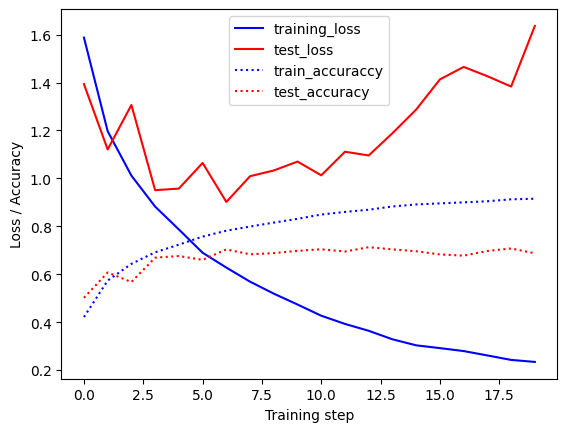

In [33]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

# Base Model with learning rate 0.05 and Adam

In [37]:
# define log lists
train_losses        = []
train_accuracies    = []
test_losses         = []
test_accuracies     = []

In [41]:
# hyperparameters
epochs          = 15   
loss_function   = tf.losses.CategoricalCrossentropy()
learning_rate   = 0.05
optimizer       = tf.optimizers.Adam(learning_rate)

In [42]:
model_2 = Cifar10Model()

In [44]:
# train
train_losses, train_accuracies, test_losses, test_accuracies = train_model(epochs, model_2, train_dataset, test_dataset, loss_function, optimizer,\
                                                                            train_losses, train_accuracies, test_losses, test_accuracies)

Epoch: 14; accuracy: 0.125


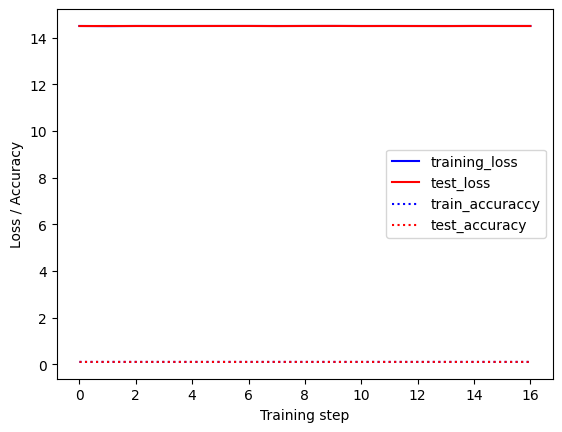

In [45]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

# Base Model with learning rate 0.25 and SGD

In [51]:
# define log lists
train_losses        = []
train_accuracies    = []
test_losses         = []
test_accuracies     = []

In [52]:
# hyperparameters
epochs          = 15   
loss_function   = tf.losses.CategoricalCrossentropy()
learning_rate   = 0.25
optimizer       = tf.optimizers.Adam(learning_rate)

In [53]:
model_3 = Cifar10Model()

In [54]:
# train
train_losses, train_accuracies, test_losses, test_accuracies = train_model(epochs, model_3, train_dataset, test_dataset, loss_function, optimizer,\
                                                                            train_losses, train_accuracies, test_losses, test_accuracies)

Epoch: 14; accuracy: 0.0


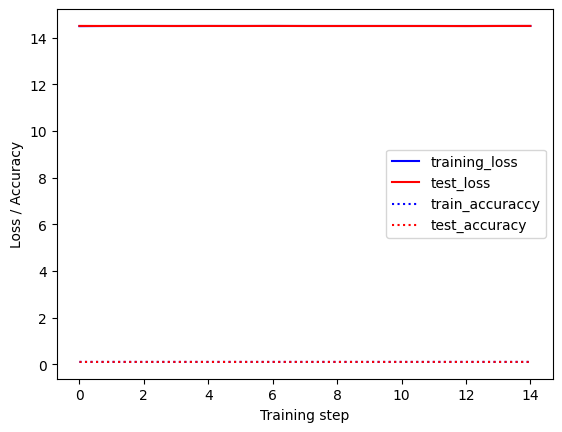

In [55]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

# Base Model with learning rate 0.25 and Adam

In [56]:
# define log lists
train_losses        = []
train_accuracies    = []
test_losses         = []
test_accuracies     = []

In [57]:
# hyperparameters
epochs          = 15   
loss_function   = tf.losses.CategoricalCrossentropy()
learning_rate   = 0.25
optimizer       = tf.optimizers.Adam(learning_rate)

In [58]:
model_4 = Cifar10Model()

In [59]:
# train
train_losses, train_accuracies, test_losses, test_accuracies = train_model(epochs, model_4, train_dataset, test_dataset, loss_function, optimizer,\
                                                                            train_losses, train_accuracies, test_losses, test_accuracies)

Epoch: 14; accuracy: 0.125


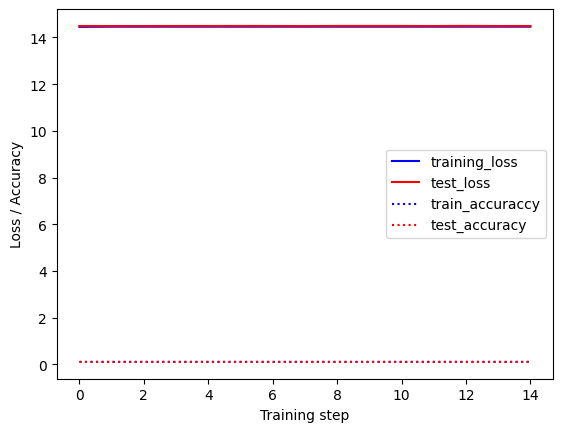

In [60]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

# Second Architecture

In [61]:
class Cifar10Model_2(tf.keras.Model):
    
    def __init__(self):
        super(Cifar10Model_2, self).__init__()

        self.conv_1 = Conv2D(filters=24, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3))
        self.conv_2 = Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.pool_1 = MaxPooling2D(pool_size=2, strides=2)

        self.conv_3 = Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.conv_4 = Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.global_pool = GlobalAvgPool2D()

        self.out = Dense(10, activation='softmax')

    @tf.function
    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_1(x)

        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.global_pool(x)
        
        x = self.out(x)
        return x

# Second Model with learning rate 0.05 and SGD

In [62]:
# define log lists
train_losses        = []
train_accuracies    = []
test_losses         = []
test_accuracies     = []

In [63]:
# hyperparameters
epochs          = 15   
loss_function   = tf.losses.CategoricalCrossentropy()
learning_rate   = 0.05
optimizer       = tf.optimizers.SGD(learning_rate)

In [64]:
model_5 = Cifar10Model()

In [65]:
# train
train_losses, train_accuracies, test_losses, test_accuracies = train_model(epochs, model_5, train_dataset, test_dataset, loss_function, optimizer,\
                                                                            train_losses, train_accuracies, test_losses, test_accuracies)

Epoch: 14; accuracy: 0.5


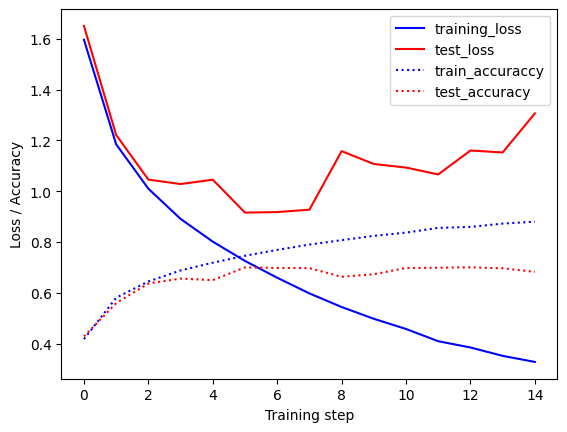

In [66]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

# Second Model with learning rate 0.05 and Adam

In [67]:
# define log lists
train_losses        = []
train_accuracies    = []
test_losses         = []
test_accuracies     = []

In [68]:
# hyperparameters
epochs          = 15   
loss_function   = tf.losses.CategoricalCrossentropy()
learning_rate   = 0.05
optimizer       = tf.optimizers.Adam(learning_rate)

In [69]:
model_6 = Cifar10Model()

In [70]:
# train
train_losses, train_accuracies, test_losses, test_accuracies = train_model(epochs, model_6, train_dataset, test_dataset, loss_function, optimizer,\
                                                                            train_losses, train_accuracies, test_losses, test_accuracies)

Epoch: 14; accuracy: 0.0625


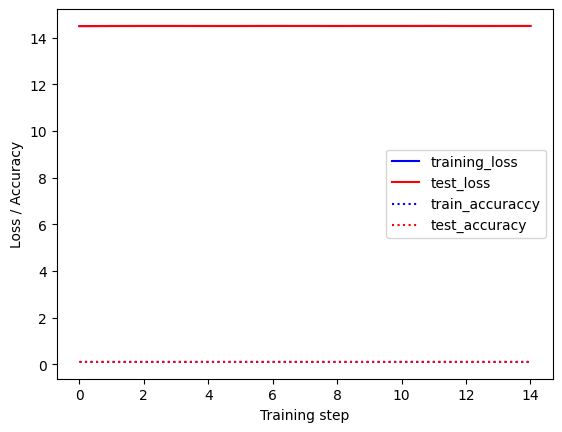

In [71]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

# Second Model with learning rate 0.25 and SGD

In [72]:
# define log lists
train_losses        = []
train_accuracies    = []
test_losses         = []
test_accuracies     = []

In [73]:
# hyperparameters
epochs          = 15   
loss_function   = tf.losses.CategoricalCrossentropy()
learning_rate   = 0.25
optimizer       = tf.optimizers.SGD(learning_rate)

In [74]:
model_7 = Cifar10Model()

In [75]:
# train
train_losses, train_accuracies, test_losses, test_accuracies = train_model(epochs, model_7, train_dataset, test_dataset, loss_function, optimizer,\
                                                                            train_losses, train_accuracies, test_losses, test_accuracies)

Epoch: 14; accuracy: 0.9375


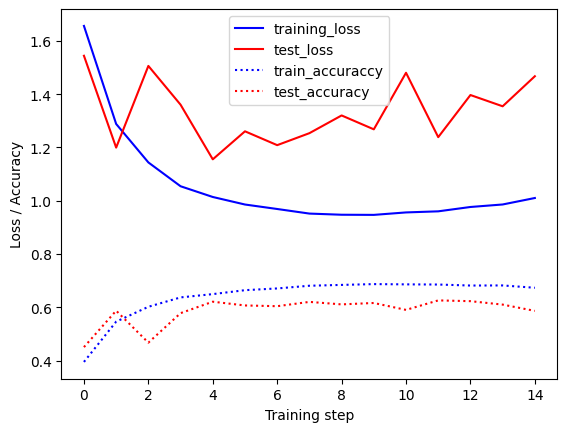

In [76]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

# Second Model with learning rate 0.25 and Adam

In [77]:
# define log lists
train_losses        = []
train_accuracies    = []
test_losses         = []
test_accuracies     = []

In [78]:
# hyperparameters
epochs          = 15   
loss_function   = tf.losses.CategoricalCrossentropy()
learning_rate   = 0.25
optimizer       = tf.optimizers.Adam(learning_rate)

In [79]:
model_8 = Cifar10Model()

In [80]:
# train
train_losses, train_accuracies, test_losses, test_accuracies = train_model(epochs, model_8, train_dataset, test_dataset, loss_function, optimizer,\
                                                                            train_losses, train_accuracies, test_losses, test_accuracies)

Epoch: 14; accuracy: 0.125


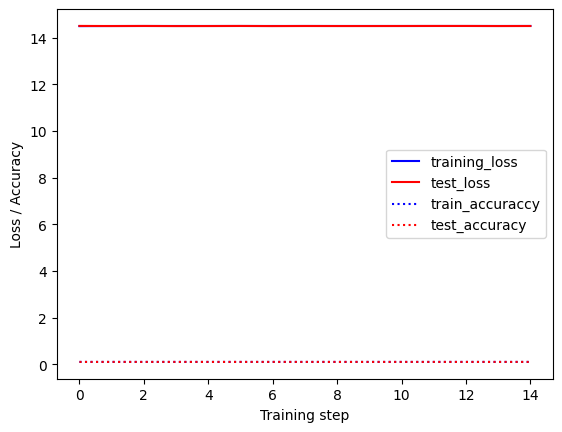

In [81]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)